In [1]:
import pandas as pd
from py2neo import Graph
graph = Graph("bolt://localhost:7687", user='neo4j', password='newPassword')
# graph = Graph()

In [5]:
import matplotlib 
import matplotlib.pyplot as plt

In [3]:
# https://neo4j.com/graphacademy/online-training/data-science/part-2/
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
1,Merchant,578685
0,Client,2216269


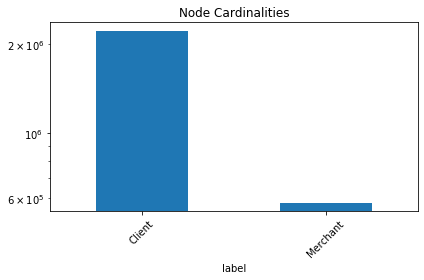

In [6]:

nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
0,TRANSACTED_AT,17919151


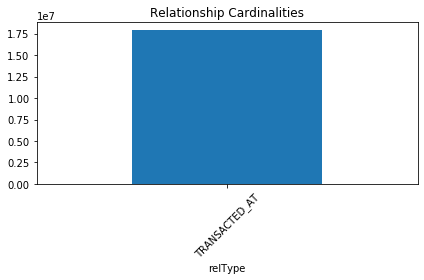

In [8]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
exploratory_query = """
MATCH (merchant1:Merchant {franchisename:'DIS-CHEM DAINFERN'})<-[:TRANSACTED_AT]-(client:Client)-[:TRANSACTED_AT]->(merchant2:Merchant)
WHERE merchant1<>merchant2
RETURN merchant1.franchisename AS merchant1, client.dedupestatic AS dedupestatic,  merchant2.franchisename AS merchant2, 
       size((merchant1)-[:TRANSACTED_AT]-()) AS merchant1_transactions, 
       size((merchant2)-[:TRANSACTED_AT]-()) AS merchant2_transactions
ORDER BY rand()
LIMIT 25
"""

graph.run(exploratory_query).to_data_frame()

,merchant1,dedupestatic,merchant2,merchant1_transactions,merchant2_transactions
0,DIS-CHEM DAINFERN,1.10231270801e+11,Spar Broad A,252,51
1,DIS-CHEM DAINFERN,1.10231270801e+11,FOURWAYS GAR,252,533
2,DIS-CHEM DAINFERN,1.10231270801e+11,WOOLWORTHS- BR,252,2110
3,DIS-CHEM DAINFERN,1.10231270801e+11,Clicks Fourway,252,1736
4,DIS-CHEM DAINFERN,1.10231270801e+11,BUILDERS EXP C,252,1889
5,DIS-CHEM DAINFERN,1.10231270801e+11,Spar Broadacre,252,2574
6,DIS-CHEM DAINFERN,1.10231270801e+11,FOURNOS FOURWA,252,14
7,DIS-CHEM DAINFERN,1.10231270801e+11,HERBERT EVAN,252,412
8,DIS-CHEM DAINFERN,1.10231270801e+11,PNA DAINFERN,252,379
9,DIS-CHEM DAINFERN,1.10231270801e+11,Dainfern squar,252,242


In [15]:
query = """
MATCH (m:Merchant {companyname:'DISCHEM'})-[transaction:TRANSACTED_AT]-(client:Client)
RETURN m.franchisename AS Merchant, count(transaction) AS transactions
"""

citation_df = graph.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,transactions
count,1544.000000
mean,194.995466
std,415.986285
min,1.000000
25%,3.000000
50%,31.000000
75%,180.250000
90%,505.500000
99%,2008.410000
max,4016.000000


In [ ]:
result=graph.run("""MATCH (merchant:Merchant {franchisename:'DIS-CHEM DAINFERN'})
RETURN merchant.companyname """).data()

In [ ]:
nodes = [n for n in result]

In [ ]:
nodes

In [ ]:
my_node = graph.run("""MATCH (merchant:Merchant {companyname:'DISCHEM'})
RETURN merchant """).data()

In [ ]:
my_node

In [ ]:
my_node = graph.run("""MATCH (merchant:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client) 
RETURN merchant.franchisename, c.dedupestatic """).data()

In [ ]:
len(my_node)

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client)-
[:TRANSACTED_AT]-(other:Merchant)
WHERE other.franchisename<>dischem.franchisename 
RETURN dischem.franchisename, c.dedupestatic, other.franchisename, other.companyname""").data()

In [ ]:
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client)-
[:TRANSACTED_AT]-(other:Merchant)
WHERE other.franchisename<>dischem.franchisename 
RETURN DISTINCT(c.dedupestatic), count(DISTINCT other)""").data()
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client)-
[othertransaction:TRANSACTED_AT]-(other:Merchant)
WHERE other.franchisename<>dischem.franchisename 
RETURN DISTINCT(other.franchisename) AS other_franchisename, count(othertransaction) AS number_transactions""").data()
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client)-
[othertransaction:TRANSACTED_AT]-(other:Merchant)
WHERE other.franchisename<>dischem.franchisename 
WITH other.franchisename AS other_franchisename, count(othertransaction) AS number_transactions 
RETURN DISTINCT(other_franchisename), number_transactions""").data()
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c0:Client)
MATCH (c1:Client {dedupestatic:'2.11279273006e+11'})  
WHERE c0.dedupestatic <> c1.dedupestatic  
RETURN gds.alpha.linkprediction.commonNeighbors(c0, c1)""").data()
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c0:Client) 
MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c1:Client) 
WHERE c0.dedupestatic <> c1.dedupestatic AND gds.alpha.linkprediction.commonNeighbors(c0, c1)>5 
RETURN c0.dedupestatic, c1.dedupestatic, gds.alpha.linkprediction.commonNeighbors(c0, c1) as commons""").data()
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c0:Client)
WITH collect(distinct c0) as clients 
MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c1:Client) 
WHERE c1 NOT in clients AND gds.alpha.linkprediction.commonNeighbors(c0, c1)>5 
RETURN c0.dedupestatic, c1.dedupestatic""").data()
my_node

In [ ]:
 MATCH (p1:Person {name: 'Michael'})
 MATCH (p2:Person {name: 'Karin'})
 RETURN gds.alpha.linkprediction.commonNeighbors(p1, p2) AS score

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c0:Client) 
MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c1:Client)
WHERE c0.dedupestatic <> c1.dedupestatic  
RETURN DISTINCT(c0.dedupestatic), DISTINCT(c1.dedupestatic)""").data()
my_node

#### Peek into the file:

In [ ]:
my_node = graph.run("""MATCH (merchant:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client) 
RETURN merchant.franchisename, c.dedupestatic """).data()

In [ ]:
data

In [ ]:
# crimes_header.csv
filename='/var/lib/neo4j/import/beats.csv'
beats = pd.read_csv(filename,nrows=10)
beats

In [ ]:
# crimes_header.csv
filename='/var/lib/neo4j/import/crimes_header.csv'
crimes_header_csv = pd.read_csv(filename,nrows=10)
crimes_header_csv

In [ ]:
filename='/var/lib/neo4j/import/crimes.csv'
crimes_csv = pd.read_csv(filename,nrows=10)
crimes_csv

In [ ]:
import csv
filename='/media/lnr-ai/christo/github_repos/graphing/data/clientswipes_202003_neo4j.csv'
with open(filename) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0

In [ ]:
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
            line_count += 1
    print(f'Processed {line_count} lines.')

In [ ]:
dedupegroup_list=list(set(df.Dedupegroup))

In [ ]:
for dedupestatic in list(set(dedupegroup_list)):
    print('Doing dedupestatic: ', dedupestatic, ' at index: ', dedupegroup_list.index(dedupestatic), ' of ', len(dedupegroup_list))        
    client_param_dict={"dedupestatic":dedupestatic}
    graph.run("MERGE (client:Client {dedupestatic:{dedupestatic}})", client_param_dict)

In [ ]:
for dedupe in dedupegroup_list:
    gf=df[df.Dedupegroup==dedupe].copy()
    print('Doing dedupestatic: ', dedupe, ' at index: ', dedupegroup_list.index(dedupe), ' of ', len(dedupegroup_list))    
    for dedupestatic,companyname,franchisename,companyindex,class_id,discretionary,division_id,group_id,subclass_id,channel,TransactionAmount,TransactionDate in zip(gf.Dedupegroup, gf.companyname, gf.franchisename,gf.companyindex,gf.class_id,gf.discretionary,gf.division_id,gf.group_id,gf.subclass_id,gf.channel,gf.TransactionAmount,gf.TransactionDate):

        client_param_dict={"dedupestatic":dedupestatic}
        company_param_dict={"companyname":companyname,
                  "franchisename":franchisename,
                  "companyindex":companyindex,
                  "class_id":class_id,
                  "discretionary":discretionary,
                  "division_id":division_id,
                  "group_id":group_id,
                  "subclass_id":subclass_id,
                  "channel":channel}
        franchise_param_dict={
              "franchisename":franchisename,"companyname":companyname,}
        transaction_param_dict={"dedupestatic":dedupestatic,
              "franchisename":franchisename,
    #           "companyindex":companyindex,
              "amount":amount,
              "date":date}
        owner_param_dict={"companyname":companyname,
              "franchisename":franchisename}
    #   ------------------------------------------------------------------------------------------
        graph.run("MERGE (client:Client {dedupestatic:{dedupestatic}})", client_param_dict)
    #   ------------------------------------------------------------------------------------------    
        graph.run("""MERGE (franchise:Franchise 
        {
        franchisename:{franchisename},
        companyname:{companyname}})
        """, franchise_param_dict)
    #   ------------------------------------------------------------------------------------------
        graph.run("""
        MERGE (company:Company 
        {
        companyname: {companyname}, 
        companyindex: {companyindex}}) ON CREATE SET company.channel={channel},
        company.class_id={class_id},
        company.discretionary={discretionary},
        company.division_id={division_id},
        company.group_id={group_id},
        company.subclass_id={subclass_id},
        company.channel={channel}
        """, company_param_dict)
    #   ------------------------------------------------------------------------------------------
        graph.run("""MATCH (client:Client {dedupestatic:{dedupestatic}}),(franchise:Franchise { franchisename: {franchisename} })
        MERGE (client)-[t:transacted]->(franchise)
        ON CREATE SET t.amount=[{amount}], t.date=[{date}]
        ON MATCH SET t.amount=t.amount+{amount}, t.date=t.date+{date}""", transaction_param_dict)
    #   ------------------------------------------------------------------------------------------
        graph.run("""MATCH (franchise:Franchise {franchisename:{franchisename}}),(company:Company { companyname: {companyname} })
        MERGE (franchise)-[t:owned]->(company)""", owner_param_dict)    

In [ ]:
dedupestatic=dedupegroup_list[0]
companyname=list(gf.companyname)[0]
franchisename=list(gf.franchisename)[0]
companyindex=list(gf.companyindex)[0]
class_id=list(gf.class_id)[0]
discretionary=list(gf.discretionary)[0]
division_id=list(gf.division_id)[0]
group_id=list(gf.group_id)[0]
subclass_id=list(gf.subclass_id)[0]
channel=list(gf.channel)[0]
amount=list(gf.TransactionAmount)[0]
date=list(gf.TransactionDate)[0]
# companyindex=list(gf.companyindex)[0]
# class_id=list(gf.class_id)[0]
# discretionary=list(gf.discretionary)[0]
# division_id=list(gf.division_id)[0]
# group_id=list(gf.group_id)[0]
# subclass_id=list(gf.subclass_id)[0]
# channel=list(gf.channel)[0]

In [ ]:
client_param_dict={"dedupestatic":dedupestatic}

In [ ]:
company_param_dict={"companyname":companyname,
          "franchisename":franchisename,
          "companyindex":companyindex,
          "class_id":class_id,
          "discretionary":discretionary,
          "division_id":division_id,
          "group_id":group_id,
          "subclass_id":subclass_id,
          "channel":channel}

In [ ]:
franchise_param_dict={
          "franchisename":franchisename,"companyname":companyname,}

In [ ]:
transaction_param_dict={"dedupestatic":dedupestatic,
          "franchisename":franchisename,
#           "companyindex":companyindex,
          "amount":amount,
          "date":date}

In [ ]:
owner_param_dict={"companyname":companyname,
          "franchisename":franchisename}

In [ ]:
graph.run("MERGE (client:Client {dedupestatic:{dedupestatic}})", client_param_dict)

In [ ]:
graph.run("""
MERGE (franchise:Franchise 
{
franchisename:{franchisename},
companyname:{companyname}})
""", franchise_param_dict)

In [ ]:
graph.run("""
MERGE (company:Company 
{
companyname: {companyname}, 
companyindex: {companyindex}}) ON CREATE SET company.channel={channel},
company.class_id={class_id},
company.discretionary={discretionary},
company.division_id={division_id},
company.group_id={group_id},
company.subclass_id={subclass_id},
company.channel={channel}
""", company_param_dict)

In [ ]:
graph.run("""MATCH (client:Client {dedupestatic:{dedupestatic}}),(franchise:Franchise { franchisename: {franchisename} })
MERGE (client)-[t:transacted]->(franchise)
ON CREATE SET t.amount=[{amount}], t.date=[{date}]
ON MATCH SET t.amount=t.amount+{amount}, t.date=t.date+{date}""", transaction_param_dict)


In [ ]:
graph.run("""MATCH (franchise:Franchise {franchisename:{franchisename}}),(company:Company { companyname: {companyname} })
MERGE (franchise)-[t:owned]->(company)""", owner_param_dict)